In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import max_error, mean_absolute_error, r2_score

from scipy.optimize import minimize

In [6]:
data_df = pd.read_csv('../../raw_data/df.csv', index_col=0)

In [8]:
# data_df = df.drop(columns='Unnamed: 0')
data_df['Day'] = pd.to_datetime(data_df['Day'])
data_df_time = data_df.drop(columns='orders').copy()
data_df_time.set_index('Day', inplace=True)
# data_df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
# data_df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

In [10]:
train_idx = data_df_time.shape[0] - (int(data_df_time.shape[0] * 0.15) + 1)
train_data = data_df_time.iloc[0:train_idx+1]
train_data.shape

(668, 10)

In [12]:
test_data = data_df_time.iloc[train_idx+1:]
test_data.shape

(117, 10)

In [13]:
test_data

,total_sales,fb_costs,fb_impressions,fb_clicks,google_costs,google_impressions,google_clicks,tt_costs,tt_impressions,tt_clicks
Day,,,,,,,,,,
2023-04-30,2590.64,1186.19,300457.0,714.0,223.58,56.0,347.0,249.03,160376.0,499.0
2023-05-01,3929.04,1133.25,338892.0,830.0,237.53,70.0,508.0,249.32,150034.0,677.0
2023-05-02,4944.24,1075.99,292899.0,755.0,266.79,51.0,485.0,248.99,145325.0,1065.0
2023-05-03,4692.36,1018.00,248149.0,604.0,244.62,37.0,465.0,248.92,126744.0,812.0
2023-05-04,3239.97,1020.85,243395.0,624.0,231.57,51.0,364.0,244.00,116766.0,506.0
...,...,...,...,...,...,...,...,...,...,...
2023-08-20,13616.97,2148.53,555740.0,1366.0,466.56,70.0,801.0,368.86,199939.0,644.0
2023-08-21,15348.42,2210.01,595105.0,1284.0,400.58,51.0,782.0,391.14,186956.0,494.0
2023-08-22,6054.53,1335.84,340325.0,839.0,289.46,50.0,619.0,218.61,134032.0,398.0


In [14]:
display(pd.DataFrame(train_data.iloc[-1]))
display(pd.DataFrame(test_data.iloc[0]))

,2023-04-29
total_sales,2936.12
fb_costs,691.37
fb_impressions,156507.00
fb_clicks,430.00
google_costs,225.81
google_impressions,59.00
google_clicks,352.00
tt_costs,247.00
tt_impressions,120344.00
tt_clicks,447.00


,2023-04-30
total_sales,2590.64
fb_costs,1186.19
fb_impressions,300457.00
fb_clicks,714.00
google_costs,223.58
google_impressions,56.00
google_clicks,347.00
tt_costs,249.03
tt_impressions,160376.00
tt_clicks,499.00


In [15]:
def process_data(data_df):
    data_df['response_sales'] = data_df['total_sales'].apply(lambda x: x - data_df.total_sales.mean())
    for element in ['fb', 'google', 'tt']:
        data_df[f'{element}_response'] = data_df.apply(
                                            lambda x: x[f'{element}_clicks'] + x[f'{element}_impressions'], axis=1).copy()
    
    data_df['total_costs'] = data_df.apply(lambda x: x.fb_costs + x.google_costs + x.tt_costs, axis=1).copy()
    data_df['total_response'] = data_df.apply(
                                            lambda x: x.fb_response + x.google_response + x.tt_response, axis=1).copy()
    return data_df
    

In [16]:
train_data_proc = process_data(train_data)
test_data_proc = process_data(test_data)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_4859/1318103401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['response_sales'] = data_df['total_sales'].apply(lambda x: x - data_df.total_sales.mean())
/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_4859/1318103401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[f'{element}_response'] = data_df.apply(
/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_4859/1318103401.py:4: SettingWithCopyWarning: 
A val

In [17]:
train_data

,total_sales,fb_costs,fb_impressions,fb_clicks,google_costs,google_impressions,google_clicks,tt_costs,tt_impressions,tt_clicks,response_sales,fb_response,google_response,tt_response,total_costs,total_response
Day,,,,,,,,,,,,,,,,
2021-07-01,414.85,257.01,36200.0,129.0,1.17,39.0,20.0,0.00,0.0,0.0,-1145.983278,36329.0,59.0,0.0,258.18,36388.0
2021-07-02,229.95,250.30,33040.0,150.0,0.84,14.0,7.0,0.00,0.0,0.0,-1330.883278,33190.0,21.0,0.0,251.14,33211.0
2021-07-03,459.89,248.59,33031.0,129.0,0.72,12.0,6.0,0.00,0.0,0.0,-1100.943278,33160.0,18.0,0.0,249.31,33178.0
2021-07-04,508.36,258.05,37463.0,119.0,0.07,13.0,5.0,0.00,0.0,0.0,-1052.473278,37582.0,18.0,0.0,258.12,37600.0
2021-07-05,399.88,257.47,35963.0,142.0,0.38,34.0,16.0,0.00,0.0,0.0,-1160.953278,36105.0,50.0,0.0,257.85,36155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,3143.03,843.21,207356.0,570.0,221.43,20.0,372.0,309.39,145667.0,352.0,1582.196722,207926.0,392.0,146019.0,1374.03,354337.0
2023-04-26,3430.71,842.38,190574.0,541.0,193.30,21.0,479.0,307.25,137334.0,333.0,1869.876722,191115.0,500.0,137667.0,1342.93,329282.0
2023-04-27,4383.63,973.65,225572.0,547.0,228.49,45.0,382.0,278.99,124561.0,325.0,2822.796722,226119.0,427.0,124886.0,1481.13,351432.0


<Axes: xlabel='Day'>

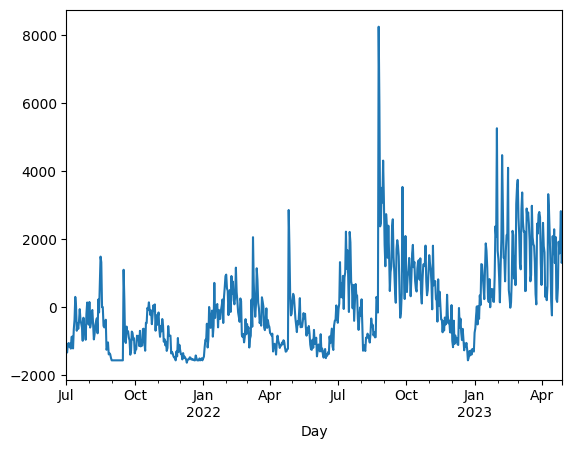

In [18]:
train_data.response_sales.plot()

In [19]:
# data_analysis = pd.DataFrame(data_df_time.index)
# data_analysis['response_sales'] = data_df['total_sales'].apply(lambda x: x - data_df.total_sales.mean())
# for element in ['fb', 'google', 'tt']:
#     data_analysis[f'{element}_response'] = data_df.apply(
#         lambda x: x[f'{element}_clicks'] + x[f'{element}_impressions'], axis=1
#         )
# for element in ['fb', 'google', 'tt']:
#     data_analysis[f'{element}_costs'] = data_df[f'{element}_costs'].copy()
# for element in ['fb', 'google', 'tt']:
#     data_analysis[f'{element}_clicks'] = data_df[f'{element}_clicks'].copy()
#     data_analysis[f'{element}_impressions'] = data_df[f'{element}_impressions'].copy()
# data_analysis['total_costs'] = data_df.apply(lambda x: x.fb_costs + x.google_costs + x.tt_costs, axis=1)
# data_analysis['total_response'] = data_analysis.apply(
#     lambda x: x.fb_response + x.google_response + x.tt_response, axis=1)

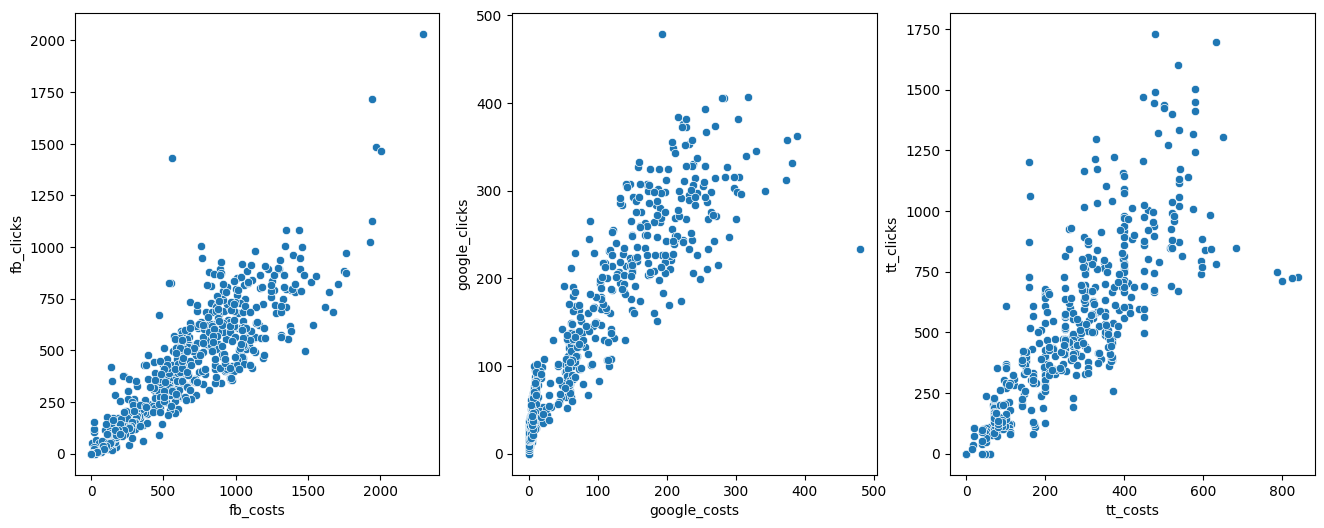

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
for idx, sm in enumerate(['fb','google', 'tt']):
    sns.scatterplot(x=f'{sm}_costs', y=f'{sm}_clicks', data=train_data_proc, ax=axs[idx])

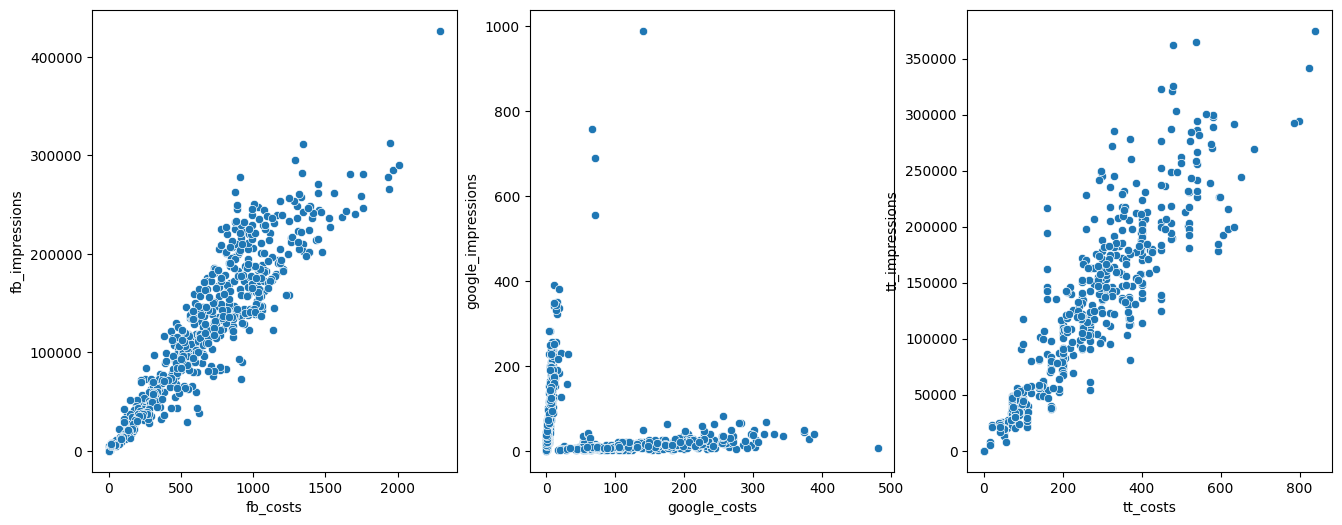

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
for idx, sm in enumerate(['fb','google', 'tt']):
    sns.scatterplot(x=f'{sm}_costs', y=f'{sm}_impressions', data=train_data_proc, ax=axs[idx])

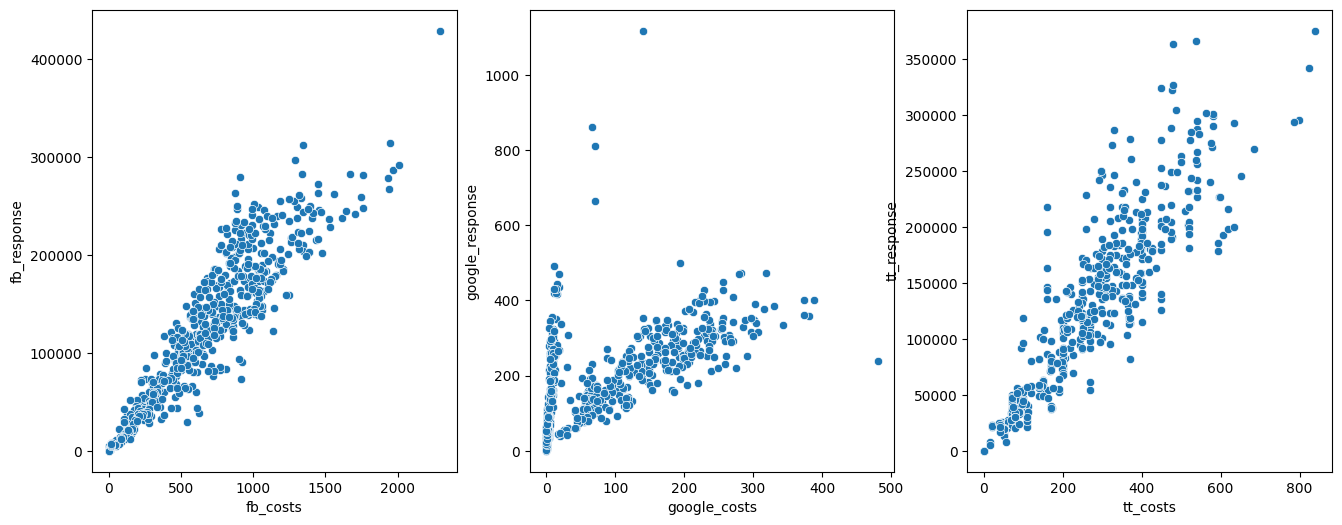

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
for idx, sm in enumerate(['fb','google', 'tt']):
    sns.scatterplot(x=f'{sm}_costs', y=f'{sm}_response', data=train_data_proc, ax=axs[idx])

<Axes: xlabel='total_costs', ylabel='response_sales'>

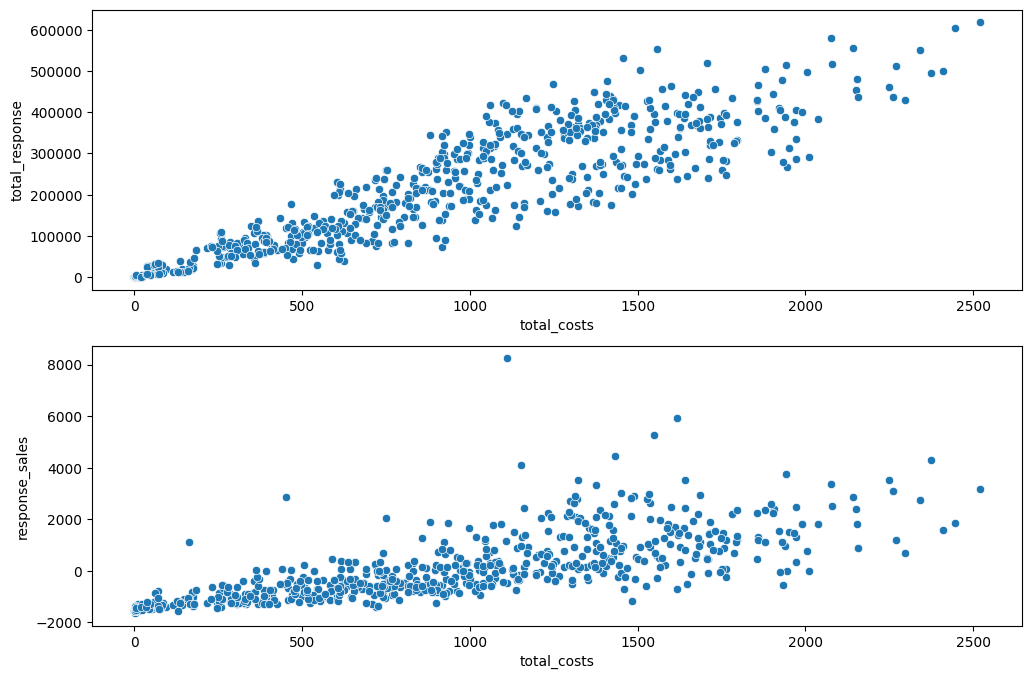

In [23]:
fig, axs = plt.subplots(2, figsize=(12, 8))

sns.scatterplot(x='total_costs', y='total_response', data=train_data_proc, ax=axs[0])
sns.scatterplot(x='total_costs', y='response_sales', data=train_data_proc, ax=axs[1])

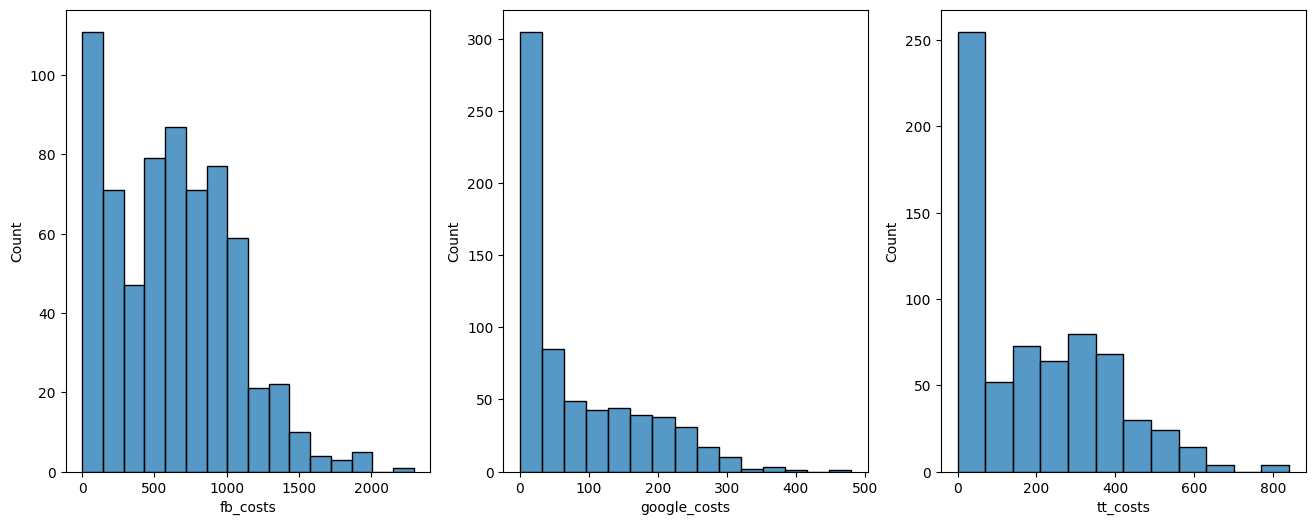

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
for idx, sm in enumerate(['fb','google', 'tt']):
    sns.histplot(train_data_proc[f'{sm}_costs'], ax=axs[idx])

In [25]:
train_data_proc.tail()

,total_sales,fb_costs,fb_impressions,fb_clicks,google_costs,google_impressions,google_clicks,tt_costs,tt_impressions,tt_clicks,response_sales,fb_response,google_response,tt_response,total_costs,total_response
Day,,,,,,,,,,,,,,,,
2023-04-25,3143.03,843.21,207356.0,570.0,221.43,20.0,372.0,309.39,145667.0,352.0,1582.196722,207926.0,392.0,146019.0,1374.03,354337.0
2023-04-26,3430.71,842.38,190574.0,541.0,193.30,21.0,479.0,307.25,137334.0,333.0,1869.876722,191115.0,500.0,137667.0,1342.93,329282.0
2023-04-27,4383.63,973.65,225572.0,547.0,228.49,45.0,382.0,278.99,124561.0,325.0,2822.796722,226119.0,427.0,124886.0,1481.13,351432.0
2023-04-28,2865.68,924.26,209660.0,460.0,174.34,62.0,286.0,249.57,152272.0,526.0,1304.846722,210120.0,348.0,152798.0,1348.17,363266.0
2023-04-29,2936.12,691.37,156507.0,430.0,225.81,59.0,352.0,247.00,120344.0,447.0,1375.286722,156937.0,411.0,120791.0,1164.18,278139.0


In [26]:
train_data_proc.columns

Index(['total_sales', 'fb_costs', 'fb_impressions', 'fb_clicks',
       'google_costs', 'google_impressions', 'google_clicks', 'tt_costs',
       'tt_impressions', 'tt_clicks', 'response_sales', 'fb_response',
       'google_response', 'tt_response', 'total_costs', 'total_response'],
      dtype='object')

### Response Sales

In [27]:
cols_X = ['fb_costs', 'google_costs', 'tt_costs']
y_train = train_data_proc['response_sales']
X_train = train_data_proc[cols_X]

In [28]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [29]:
pd.DataFrame(X_train_scaled, columns=cols_X)

,fb_costs,google_costs,tt_costs
0,0.112002,0.002434,0.000000
1,0.109078,0.001748,0.000000
2,0.108333,0.001498,0.000000
3,0.112455,0.000146,0.000000
4,0.112203,0.000791,0.000000
...,...,...,...
663,0.367461,0.460679,0.368159
664,0.367100,0.402155,0.365613
665,0.424306,0.475367,0.331985
666,0.402782,0.362710,0.296976


In [30]:
estimator_ = LinearRegression()
results = cross_validate(estimator=estimator_, X=X_train_scaled, y=y_train, cv=5, scoring=['r2', 'max_error'])

In [31]:
results['test_r2']

array([-0.62620625,  0.7400978 ,  0.5748863 ,  0.20030456,  0.20769605])

In [32]:
results['test_max_error']

array([-2289.29206356, -2194.49939208, -3307.6292943 , -7775.73978253,
       -4296.48226601])

In [33]:
model1 = LinearRegression()
model1.fit(X_train_scaled, y_train)


LinearRegression()

In [34]:
y_pred = model1.predict(X_train_scaled)
print(f'r2: {r2_score(y_train, y_pred)}')
print(f'max_error: {max_error(y_train, y_pred)}')

r2: 0.6583730772737979
max_error: 7892.102753830832


### Total Response

In [35]:
estimator_ = LinearRegression()
y_train_ = train_data_proc['total_response']
results = cross_validate(estimator=estimator_, X=X_train_scaled, y=y_train_, cv=5, scoring=['r2', 'max_error'])

In [36]:
print(results['test_r2'])

[0.23017715 0.89343535 0.93439977 0.57144854 0.44271744]


In [37]:
results['test_max_error']

array([-176567.41992673, -201487.7210753 ,  -77988.15210327,
       -187211.01044494, -214920.97272784])

In [38]:
model1 = LinearRegression()
model1.fit(X_train_scaled, y_train_)


LinearRegression()

In [39]:
y_pred = model1.predict(X_train_scaled)
print(f'r2: {r2_score(y_train_, y_pred)}')
print(f'max_error: {max_error(y_train_, y_pred)}')

r2: 0.8995473966391168
max_error: 185213.90192173692


### Response clicks

In [40]:
model = LinearRegression()
y_train_clicks = train_data_proc['fb_clicks'] + train_data_proc['google_clicks'] + train_data_proc['tt_clicks']
model.fit(X_train_scaled, y_train_clicks)

LinearRegression()

In [41]:
y_pred = model.predict(X_train_scaled)
print(f'r2: {r2_score(y_train_clicks, y_pred)}')
print(f'max_error: {max_error(y_train_clicks, y_pred)}')

r2: 0.8577135432058154
max_error: 1101.0239371872178


In [42]:
model.score(X_train_scaled, y_train_clicks)

0.8577135432058154

In [43]:
model.coef_

array([1316.92189154, -178.2941228 , 2002.85772555])

In [44]:
X_train_scaled

array([[0.11200206, 0.00243415, 0.        ],
       [0.10907791, 0.0017476 , 0.        ],
       [0.10833272, 0.00149794, 0.        ],
       ...,
       [0.42430568, 0.4753672 , 0.33198472],
       [0.40278208, 0.36270961, 0.29697633],
       [0.30129124, 0.46979154, 0.29391816]])

### Optimization using scipy

In [45]:
# 0: Weekend
# 1: fb
# 2: google
# 3: tiktok

In [46]:
def linfunction(b, X):
    return b[0] + np.dot(X, b[1:])

def sumsquareerrors(b, X, y_true):
    y_pred = linfunction(b, X)
    return np.mean((y_true - y_pred)**2)

In [47]:
bounds = ((None, None), (0, None), (0, None), (0, None), (0, None))

In [48]:
b0 = np.ones(4)


In [49]:
b0.shape

(4,)

In [50]:
np.mean((linfunction(b0, X_train_scaled[0:10]) - linfunction(b0, X_train_scaled[10:20]))**2)

0.04308684200801214

In [51]:
X_train_scaled[-10:].shape

(10, 3)

In [52]:
np.dot(X_train_scaled[-10:], b0[1:]) + b0[0]

array([2.00413598, 1.85519791, 1.84147135, 2.09779854, 2.15389038,
       2.19629973, 2.13486783, 2.2316576 , 2.06246801, 2.06500093])

In [53]:
X_train_scaled[-10:]

array([[0.32901612, 0.30830525, 0.36681462],
       [0.29031372, 0.22073815, 0.34414603],
       [0.22200384, 0.2746432 , 0.3448243 ],
       [0.37625562, 0.37831315, 0.34322977],
       [0.35347258, 0.44954854, 0.35086926],
       [0.3674614 , 0.46067907, 0.36815926],
       [0.3670997 , 0.40215537, 0.36561277],
       [0.42430568, 0.4753672 , 0.33198472],
       [0.40278208, 0.36270961, 0.29697633],
       [0.30129124, 0.46979154, 0.29391816]])

In [54]:
bounds = ((None, None), (0, None), (0, None), (0, None))

In [55]:
res = minimize(sumsquareerrors, x0=b0, args=(X_train_scaled, y_train_clicks), bounds=bounds)

In [56]:
res.x

array([ 116.55364202, 1287.78911583,    0.        , 1918.31935826])

In [57]:
mean_absolute_error(y_train_clicks, linfunction(res.x, X_train_scaled))

170.73693744203823

In [58]:
pd.DataFrame(X_train_scaled, columns=cols_X).google_costs.describe()

count    668.000000
mean       0.167191
std        0.190538
min        0.000000
25%        0.005394
50%        0.116860
75%        0.304436
max        1.000000
Name: google_costs, dtype: float64

In [59]:
train_data.google_costs.describe()

count    668.000000
mean      80.361946
std       91.584029
min        0.000000
25%        2.592500
50%       56.170000
75%      146.330000
max      480.660000
Name: google_costs, dtype: float64